## Edge effect jitter in BLS which leads to additional noise

This tutorial shows the effect, as described in our paper ([Hippke & Heller 2019, appendix B](https://arxiv.org/pdf/1901.02015.pdf)).

The original BLS implementation did not account for transit events occurring to be divided between the first and the last bin of the folded light curve. This was noted by Peter R. McCullough in 2002, and an updated version of BLS was made (ee-bls.f) to account for this edge effect. The patch is commonly realized by extending the phase array through appending the first bin once again at the end, so that a split transit is stitched together, and
present once in full length. The disadvantage of this approach has apparently been ignored: The test statistic is affected by a small amount of additional noise. Depending on the trial period, a transit signal (if present) is sometimes partly located in the first and the second bin. The lower (in-transit) flux values from the first bin are appended at the end of the data, resulting in a change of the ratio between out-of-transit and in-transit flux.
There are phase-folded periods with one, two, or more than two bins which contain the in-transit flux. This causes a variation (over periods) of the summed noise floor, resulting in additional jitter in the test statistic. For typical Kepler light curves, the reduction in detection efficiency is comparable to a reduction in transit depth of ∼ 0.1 − 1 %. TLS corrects this effect by subtracting the difference of the summed residuals between the patched
and the non-patched phased data. A visualization of this effect on the statistic is shown in Fig. B.1, using synthetic data. In real data, the effect is usually overpowered by noise, and was thus ignored, but is nonetheless present.

We start by creating synthetic test data:

In [7]:
import numpy
import batman
from transitleastsquares import transitleastsquares, period_grid
from astropy.stats import BoxLeastSquares

# Create empty time series to inject transits and noise
numpy.random.seed(seed=0)  # reproducibility 
start = 12
days = 365.25 * 3
samples_per_day = 12
samples = int(days * samples_per_day)
t = numpy.linspace(start, start + days, samples)

# Use batman to create transits
ma = batman.TransitParams()
ma.t0 = start + 20 # time of inferior conjunction; first transit is X days after start
ma.per = 365.25  # orbital period
ma.rp = 6371 / 696342  # 6371 planet radius (in units of stellar radii)
ma.a = 217  # semi-major axis (in units of stellar radii)
ma.inc = 90  # orbital inclination (in degrees)
ma.ecc = 0  # eccentricity
ma.w = 90  # longitude of periastron (in degrees)
ma.u = [0.5, 0.5]  # limb darkening coefficients
ma.limb_dark = "quadratic"  # limb darkening model
m = batman.TransitModel(ma, t)  # initializes model
original_flux = m.light_curve(ma)  # calculates light curve

# Create noise and merge with flux
ppm = 5
stdev = 10**-6 * ppm
noise = numpy.random.normal(0, stdev, int(samples))
y = original_flux + noise
y_box = numpy.copy(y)
t_box = numpy.copy(t)

Now, we search these data with TLS and BLS:

In [4]:
# Search with TLS
model = transitleastsquares(t, y)
results = model.power(
    period_min=360,
    period_max=370,
    transit_depth_min=ppm*10**-6,
    oversampling_factor=10,
    duration_grid_step=1.02,
    u=[0.4, 0.4],
    limb_dark='quadratic',
    M_star = 1,
    M_star_max=1.1
    )

# Search with BLS
periods = period_grid(
    R_star=1,
    M_star=1,
    time_span=(max(t) - min(t)),
    period_min=360,  # 10.04
    period_max=370,  # 10.05
    oversampling_factor=10)
durations = numpy.linspace(0.2, 0.7, 50)
model = BoxLeastSquares(t_box, y_box)
results_bls = model.power(periods, durations)

# Flatten the BLS periodogram for comparability
chi2 = 1 / results_bls.power
SR = min(chi2) / chi2
SDE = (1 - numpy.mean(SR)) / numpy.std(SR)
SDE_power = SR - numpy.min(SR)      # shift down to touch 0
scale = SDE / numpy.max(SDE_power)  # scale factor to touch max=SDE
SDE_power = SDE_power * scale

Transit Least Squares TLS 1.0.7 (04 January 2019)
Creating model cache for 86 durations
Searching 13149 data points, 555 periods from 360.012 to 369.983 days, using all 8 CPU threads


100%|██████████| 555/555 periods | 00:02<00:00
  0%|          | 23/13149 [00:00<00:57, 229.92it/s]

Searching for best T0 for period 365.24020


100%|██████████| 13149/13149 [00:02<00:00, 4509.59it/s]


Finally, we plot the result:

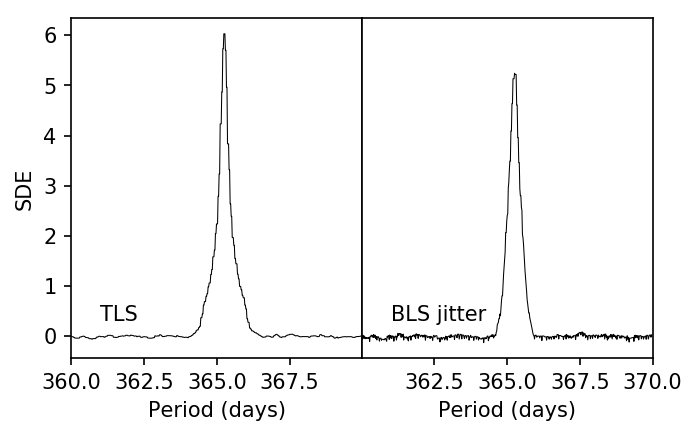

In [6]:
import matplotlib.pyplot as plt
from matplotlib import rcParams; rcParams["figure.dpi"] = 150
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(5, 3))

# TLS
axes[0].plot(
    results.periods,
    results.power - numpy.median(results.power), 
    color='black', lw=0.5)
axes[0].set_ylabel(r'SDE')
axes[0].set_xlabel('Period (days)')
axes[0].set_xlim(min(results.periods), max(results.periods))

# BLS
axes[1].plot(
    results_bls.period,
    SDE_power - numpy.median(SDE_power),
    color='black', lw=0.5)
axes[1].set_xlabel('Period (days)')
axes[1].set_xlim(min(periods), max(periods))

# Pretty plotting
plt.subplots_adjust(hspace=0)
plt.subplots_adjust(wspace=0)
axes[1].tick_params("y", left=False)
axes[0].set_xticks([360, 362.5, 365, 367.5])
axes[1].set_xticks([362.5, 365, 367.5, 370])
axes[0].text(361, 0.3, 'TLS')
axes[1].text(361, 0.3, 'BLS jitter');